# Quantum Pratical Assignment
## Iteração e Concorrência

Realizado por
Grupo 19:

    * José Pedro Ribeiro Alves A78178
    * Ricardo Nuno Alves Teixeira A85688

## 0. Introdução
Este trabalho consiste em implementar um algorítmo em Quiskit de maneira a encontrar um determinado numero dentro de uma lista não ordenada de números. O número a encontrar é determinado por: $14$ $mod$ $8 ≡ 6$ que corresponde a $\lvert 110 \rangle$.


Para resolver o problema que nos foi proposto, optamos por usar o algorítmo de Grover que tem como principal objetivo solucionar uma procura numa determinada base de dados independentemente da sua estrutura com uma otimização quadrática do tempo de execução comparado à computação clássica.

Num caso de computação clássica a complexidade média do problema era dada por $\frac{N}{2}$. Através da computação quantica ao usar o algoritmo de Grover a complexidade média do mesmo problema é $\sqrt N$.

## 1. Algoritmo de Grover

**O algoritmo de Grover está dividido em três etapas:**

    a. Inicialização
    b. Oráculo
    c. Amplificação
    

<img src="https://scx2.b-cdn.net/gfx/news/2018/groversearch.jpg" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="800 px" align="center">

<img src="https://qiskit.org/textbook/ch-algorithms/images/grover_step1.jpg" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="800 px" align="center">

### a. Inicialização

A **sobreposição quântica** é um dos princípios fundamentais da mecânica e computação quântica. O algoritmo de Grover necessita que esta sobreposição seja uniforme. Para obter a sobreposição uniforme vamos usar o gate de Hadamard.

Ao aplicar o gate de Hadamard a $n$ qubits (Transformada de Hadamard) mapeamos todos $n$ bits inicializados a $\lvert 0 \rangle$ para uma superposição de todos os estados ortogonais de $2^{n}$ na base de $\lvert 0 \rangle$ e $\lvert 1 \rangle$, onde todos esses estados ortogonais têm a mesma amplitude (a probabilidade de esse estado colapsar para o respetivo estado clássico é o quadrado da amplitude).

Geralmente, a sobreposição é criada da seguinte forma:
    $$ \lvert \psi \rangle  = H^{\bigotimes n} \lvert 0 \rangle ^ {\bigotimes n} = \frac {1}{\sqrt 2^{n}} \sum_{x=0}^{2^{n} - 1} \lvert x \rangle $$
    
Como estamos a usar 3 qubits, temos:

$$H^{3} \lvert 000 \rangle = \frac {1}{2\sqrt2}  \lvert 000 \rangle + \frac {1}{2\sqrt2}  \lvert 001 \rangle + \frac {1}{2\sqrt2}  \lvert 010 \rangle + \frac {1}{2\sqrt2}  \lvert 011 \rangle + \frac {1}{2\sqrt2}  \lvert 100 \rangle + \frac {1}{2\sqrt2}  \lvert 101 \rangle + \frac {1}{2\sqrt2}  \lvert 111 \rangle$$

Graficamente:
<img src="https://qiskit.org/textbook/ch-algorithms/images/grover_step1.jpg" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="800 px" align="center">


In [2]:
##Sendo o qr o registo quântico do circuito

def init(circuit,qr):
    circuit.h(qr)

### b. Oráculo

A ideia do oráculo é identificar e marcar a resposta pretendida. No nosso caso será o estado $\lvert 011 \rangle$. Essa mesma marcação consiste em inverter a fase do estado solução. 
Para tal temos de identificar o estado solução e utilizar o gate Z para inverter a fase desse estado.

Para o fazermos, a ideia é transformar o estado solução de tal maneira o gate CCZ produza o efeito desejado (inversão de fase). Por outras palavras, para ativar o CCZ, temos que transformar o nosso estado solução no estado $\lvert 111 \rangle$. Após fazer isto, aplicamos o CCZ e revertemos o resultado para retornar ao estado solução, mas com a fase invertida.

Graficamente, a ideia é a seguinte: 
<img src="https://qiskit.org/textbook/ch-algorithms/images/grover_step2.jpg" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="800 px" align="center">

NOTA: Visto que o gate CCZ não está definido no qiskit, implementamos a função CCZ através da composição de gates (H após CCX após H)

In [3]:
#Definicao do CCZ
def ccz(circuit, qr):
    circuit.h(qr[2])
    circuit.ccx(qr[0],qr[1],qr[2])
    circuit.h(qr[2])
    
def phase_oracle(circuit, qr):
    #muda a fase do estado |011>  -> |qr[2] qr[1] qr[0]>
    circuit.x(qr[2])
    ccz(circuit,qr)
    circuit.x(qr[2])

### c. Amplificação

Esta etapa consiste aplicar um difusor $U_D = WRW$, onde $W$ é a transformada de Hadamard e $R$ é a matriz rotação. O objetivo deste difusor é voltar a inverter a fase do estado solução e aumentar a sua amplitude, fazendo assim com que quando o estado colapsar, a probabilidade de retornar o estado solução seja consideravelmente maior.

<img src="https://qiskit.org/textbook/ch-algorithms/images/grover_step3.jpg" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="800 px" align="center">

In [4]:
def diffuser(circuit, qr):
    circuit.h(qr)
    circuit.x(qr)
    ccz(circuit, qr)
    circuit.x(qr)
    circuit.h(qr)

Para terminar, e obter os melhores resultados possiveis, o ideal é repetir os passos **b.Oráculo** e **c.Amplificador** $\sqrt N$ vezes, sendo N o número de elementos da lista.

A seguinte função implementa este circuito $f$ vezes.

In [5]:
def buildCircuitGrover(f):
    qr = QuantumRegister(x, 'q')
    cr = ClassicalRegister(x,'c')
    circuit = QuantumCircuit(qr,cr)
    
    init(circuit,qr)    
    
    for t in range(f):
        # phase oracle
        phase_oracle(circuit,qr)

        # diffuser
        diffuser(circuit,qr)
        
    circuit.measure(qr,cr)
    
    return circuit

Matemáticamente, numa situação perfeita onde não houvesse ruído, o resultado obtido seria o seguinte:

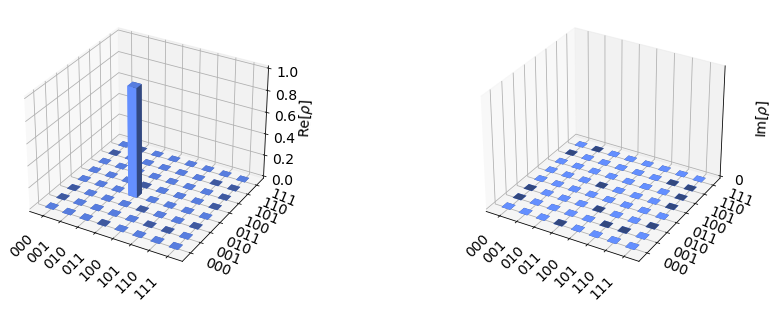

In [6]:
qc_Grover = buildCircuitGrover(2)

#STATE VECTOR 
backend_state = Aer.get_backend('statevector_simulator')
result = execute(qc_Grover, backend_state).result()
psi  = result.get_statevector(qc_Grover)
plot_state_city(psi)

/home/ricardo/anaconda3/envs/IC/lib/python3.9/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


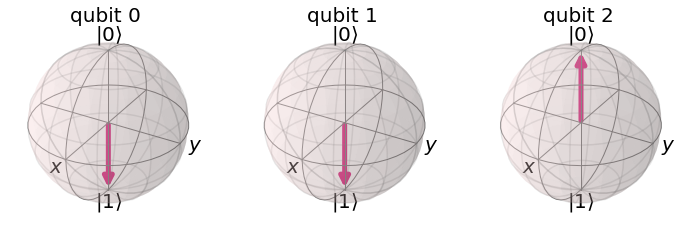

In [7]:
plot_bloch_multivector(psi)

## Simulação do ruído para prever uma melhor otimização 

Atualmente as máquinas quânticas ainda têm o chamado ruído quântico que resulta da incerteza da física quântica assim como erros provenientes da limitação de hardware (quanto maior o circuito, maior a probabilide de obter erros).
Como este ruído existe, os resultados obtidos não são perfeitos, e por isso temos que fazer uma previsão de maneira a conseguir obter os melhores resultados possíveis.

Idealmente, o número de vezes que repetimos os passos **b. Oráculo** e **c. Amplificador** $\sqrt N$ é um inteiro.
Dado que neste caso $N = 8$, e $\sqrt 8$ nao é um número inteiro tentamos repetir os passos para os dois números mais proximos (*floor* e *ceiling*), sendo eles 2 e 3.

In [8]:
import math as m
res = m.sqrt (8)
print (res)

2.8284271247461903


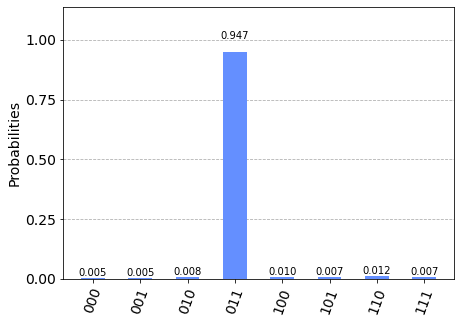

In [9]:
backend_qasm = Aer.get_backend('qasm_simulator')
shots = 1024

#SIM RUIDO for = 2
qc_Grover = buildCircuitGrover(2)
result2 = execute(qc_Grover, backend_qasm, shots=shots).result()
count = result2.get_counts(qc_Grover)
plot_histogram(count)

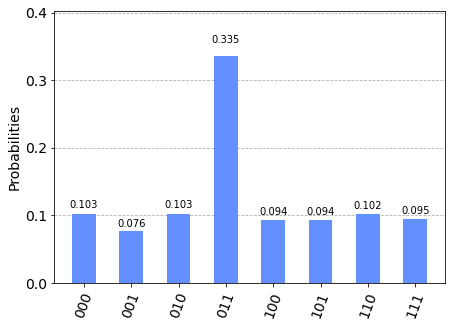

In [10]:
#SIM RUIDO for = 3
qc_Grover2 = buildCircuitGrover(3)
result3 = execute(qc_Grover2, backend_qasm, shots=shots).result()
count2 = result3.get_counts(qc_Grover2)
plot_histogram(count2)

Ao observar os resultados, concluímos que há melhorias bastante significativas de um para o outro (de $33\%$ para $94\%$). Por isso, no nosso caso, daqui para a frente, optamos por repetir os passos **b.** e **c.** apenas duas vezes

## 3. Execução numa Máquina Quântica real

In [11]:
provider = IBMQ.load_account()
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [12]:
%qiskit_backend_overview

In [13]:
backend_overview()

ibmq_manila                  ibmq_quito                   ibmq_belem
-----------                  ----------                   ----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 2              Pending Jobs: 8              Pending Jobs: 5
Least busy:   True           Least busy:   False          Least busy:   False
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      151.0          Avg. T1:      75.2           Avg. T1:      79.3
Avg. T2:      67.0           Avg. T2:      73.2           Avg. T2:      91.6



ibmq_lima                    ibmq_santiago                ibmq_athens
---------                    -------------                -----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 10             Pending Jobs: 2              Pending Jobs: 5
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operati

In [14]:
backend_device = provider.get_backend('ibmq_manila')
print("Running on: ", backend_device)

Running on:  ibmq_manila


In [15]:
# See backend information
backend_device

<IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>

In [16]:
backend_monitor(backend_device)

ibmq_manila
Configuration
-------------
    n_qubits: 5
    operational: True
    status_msg: active
    pending_jobs: 2
    backend_version: 1.0.1
    basis_gates: ['id', 'rz', 'sx', 'x', 'cx', 'reset']
    local: False
    simulator: False
    max_experiments: 75
    conditional: False
    conditional_latency: []
    n_uchannels: 8
    meas_lo_range: [[6.663214088e+18, 7.663214088e+18], [6.783322155e+18, 7.783322155e+18], [6.718928102e+18, 7.718928102e+18], [6.610142342e+18, 7.610142342e+18], [6.846997692e+18, 7.846997692e+18]]
    memory: True
    allow_q_object: True
    description: 5 qubit device
    qubit_lo_range: [[4.4627861226243666e+18, 5.462786122624367e+18], [4.338382031192193e+18, 5.338382031192193e+18], [4.5369251989712353e+18, 5.536925198971235e+18], [4.451289298021841e+18, 5.451289298021841e+18], [4.566342494178997e+18, 5.566342494178997e+18]]
    hamiltonian: {'description': 'Qubits are modeled as Duffing oscillators. In this case, the system includes higher energy st

In [20]:
%qiskit_job_watcher

job_r = execute(qc_Grover, backend_device, shots=shots)

jobID_r = job_r.job_id()

print('JOB ID: {}'.format(jobID_r))

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

JOB ID: 60bbcc84b454d035e6aa68f2


In [21]:
%qiskit_disable_job_watcher
job_get=backend_device.retrieve_job("60bbcc84b454d035e6aa68f2")

result_r = job_get.result()
counts_run = result_r.get_counts(qc_Grover)

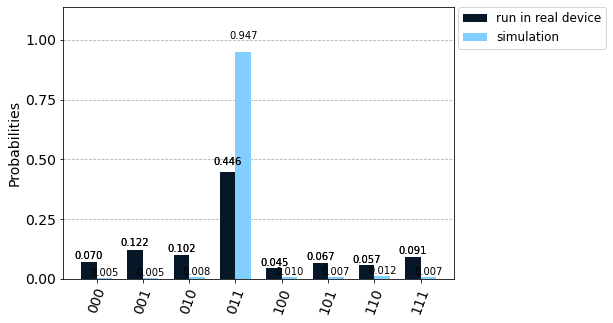

In [22]:
plot_histogram([counts_run, count ], legend=[ 'run in real device', 'simulation'], color=['#061727','#82cfff'])

Ao correr o código numa máquina real, podemos concluir que os problemas de ruído de facto existem e que atualmente as máquinas não são perfeitas.
Por isso, em computação quântica, é necessário uma atenção especial para evitar que esses mesmos erros existam.

### 3.1 Otimização

Para otimizar o nosso circuito vamos usar transpilers. Resumidamente o transpiler recebe um circuito e reformula-o de maneira a que o mesmo se alinhe melhor com a tipologia da máquina em questão tornando-o mais efeciente.
Ao alinhar o circuito com a máquina, o tempo de execução baixa, e consequentemente, como o circuito é executado mais rápido, a probabilidade de haver erros devido a ruído diminui.

Neste trabalho, vamos testar os três diferentes niveis de otimização com transpilers.

#### Otimização nivel 1

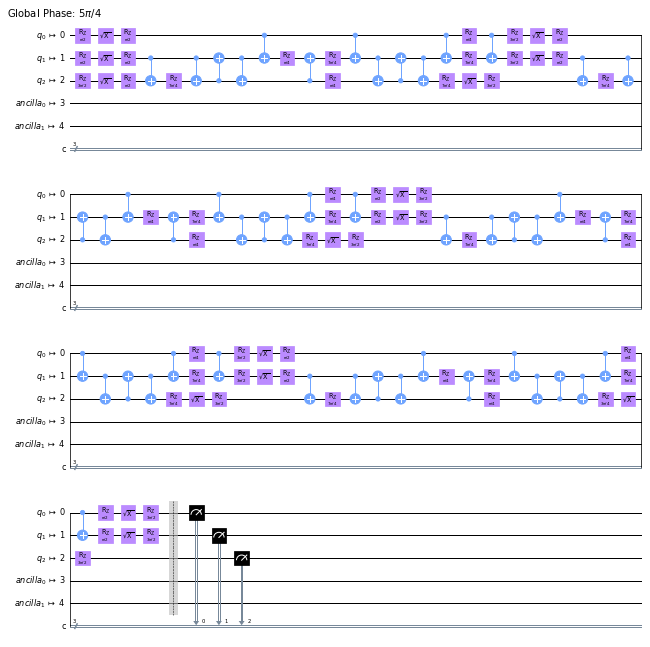

In [23]:
qc_t_real = transpile(qc_Grover, backend=backend_device)

qc_t_real.draw(output='mpl', scale=0.5)

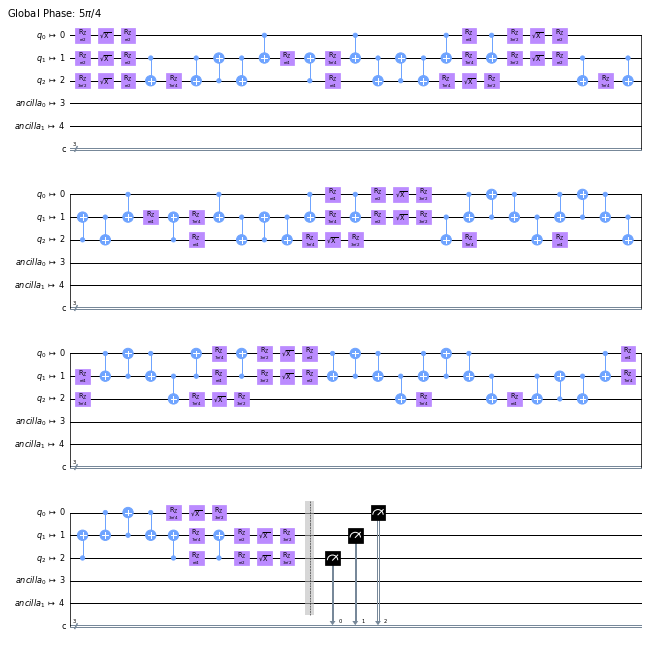

In [24]:
qc_optimized1 = transpile(qc_Grover, backend=backend_device, optimization_level=1)
qc_optimized1.draw(output='mpl', scale=0.5)

In [25]:
qc_Grover.depth()

26

In [26]:
qc_t_real.depth()

80

In [27]:
plot_circuit_layout(qc_t_real, backend_device)

qc_optimized1.depth()

86

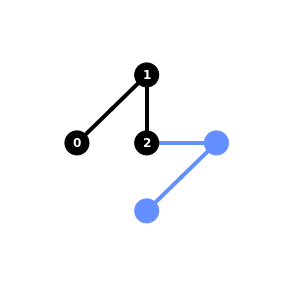

In [28]:
plot_circuit_layout(qc_optimized1, backend_device)

In [29]:
%qiskit_job_watcher
job_exp1 = execute(qc_optimized1, backend_device, shots = shots)

# job_id allows you to retrive old jobs
jobID = job_exp1.job_id()

print('JOB ID: {}'.format(jobID))

job_exp1.result().get_counts(qc_optimized1)

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

JOB ID: 60bbccf743987e3932f10627


{'000': 102,
 '001': 93,
 '010': 150,
 '011': 366,
 '100': 78,
 '101': 93,
 '110': 62,
 '111': 80}

In [30]:
#with optimization 1
job_get_o1 = backend_device.retrieve_job("60bbccf743987e3932f10627")

result_real_o1 = job_get_o1.result(timeout=3600, wait=5)

counts_opt1 = result_real_o1.get_counts(qc_optimized1)

#### Otimização nivel 2

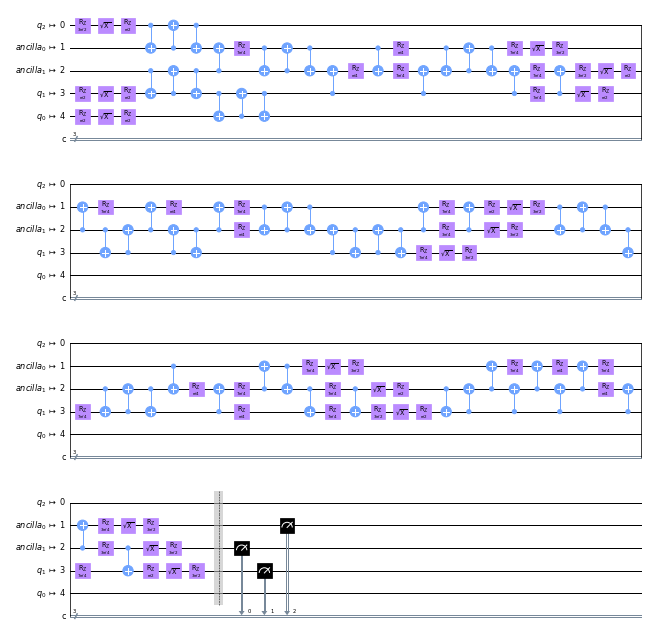

In [31]:
qc_optimized2 = transpile(qc_Grover, backend=backend_device, optimization_level=2)
qc_optimized2.draw(output='mpl', scale=0.5)

In [32]:
qc_optimized2.depth()

82

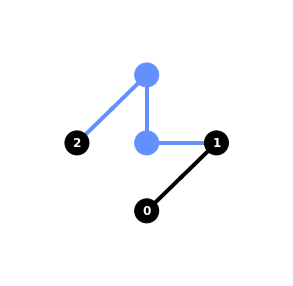

In [33]:
plot_circuit_layout(qc_optimized2, backend_device)

In [34]:
job_exp2 = execute(qc_optimized2, backend_device, shots = shots)

# job_id allows you to retrive old jobs
jobID = job_exp2.job_id()

print('JOB ID: {}'.format(jobID))

job_exp2.result().get_counts(qc_optimized2)

JOB ID: 60bbcd2225cc6ea71d65c813


{'000': 102,
 '001': 153,
 '010': 116,
 '011': 251,
 '100': 83,
 '101': 102,
 '110': 134,
 '111': 83}

In [35]:
#with optimization 2
job_get_o2 = backend_device.retrieve_job("60bbcd2225cc6ea71d65c813")

result_real_o2 = job_get_o2.result(timeout=3600, wait=5)

counts_opt2 = result_real_o2.get_counts(qc_optimized2)

#### Otimização nivel 3

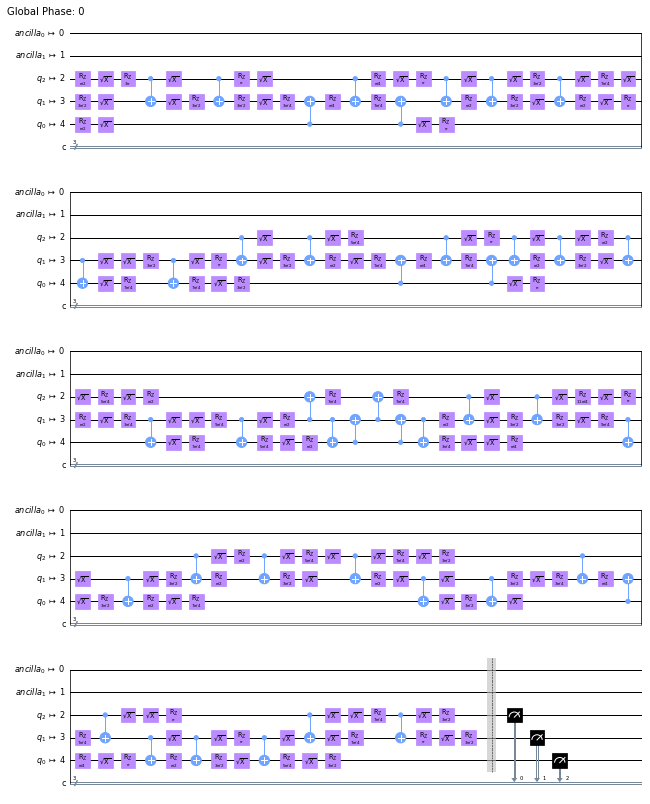

In [36]:
qc_optimized3 = transpile(qc_Grover, backend=backend_device, optimization_level=3)
qc_optimized3.draw(output='mpl', scale=0.5)

In [37]:
qc_optimized3.depth()

119

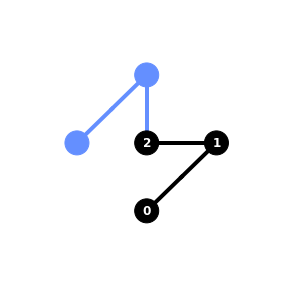

In [38]:
plot_circuit_layout(qc_optimized3, backend_device)

In [39]:
job_exp3 = execute(qc_optimized3, backend_device, shots = shots)

# job_id allows you to retrive old jobs
jobID = job_exp3.job_id()

print('JOB ID: {}'.format(jobID))

job_exp3.result().get_counts(qc_optimized3)

JOB ID: 60bbcd6100aded18c86a713d


{'000': 65,
 '001': 134,
 '010': 89,
 '011': 476,
 '100': 67,
 '101': 50,
 '110': 69,
 '111': 74}

In [40]:
#with optimization 3
job_get_o3 = backend_device.retrieve_job("60bbcd6100aded18c86a713d")

result_real_o3 = job_get_o3.result(timeout=3600, wait=5)

counts_opt3 = result_real_o3.get_counts(qc_optimized3)
%qiskit_disable_job_watcher

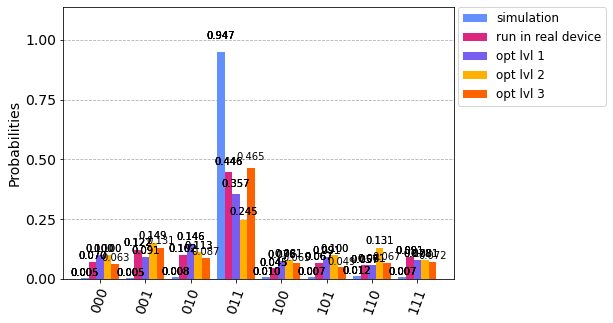

In [41]:
plot_histogram([count, counts_run, counts_opt1, counts_opt2, counts_opt3], legend=[ 'simulation', 'run in real device', "opt lvl 1", "opt lvl 2", "opt lvl 3"])

Como podemos ver no gráfico em cima, obtemos melhores resultados quando usamos o transpiler com optmização de nível 3. Nos restantes pontos deste trabalho vamos usar estes resultados em vez dos resultados sem optimização.

## 4.  Mitigação dos erros

Neste trabalhos vamos usar o **Qiskit Ignis**. O Qiskit Ignis é uma *framework* que tenta entender e mitigar o ruído de circuitos quânticos.

### Calibration Matrices

#### a. Gerar uma lista de circuitos de calibração de medida
Cada circuito cria um estado base. Dados que a número máximo de bits é 3, temos de criar $2^3 = 8$ circuitos.


In [42]:
# Generate the calibration circuits
qr = QuantumRegister(x)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr, circlabel='mcal')
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

#### b. Computar a matrix de calibração


Se não houvesse ruído na máquina, a matriz de calibração seria a matriz $Id_{8x8}$. Como esta matriz é computada numa máquina quântica, vai sempre existir algum ruído que a vai alterar.

In [43]:
%qiskit_job_watcher
job_ignis = execute(meas_calibs, backend=backend_device, shots=shots)

jobID_run_ignis = job_ignis.job_id()

print('JOB ID: {}'.format(jobID_run_ignis))

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

JOB ID: 60bbce581eb0244d01ceeb66


In [44]:
job_get=backend_device.retrieve_job("60bbce581eb0244d01ceeb66")

cal_results = job_get.result()

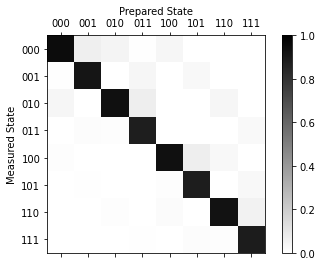

In [45]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

# Plot the calibration matrix
meas_fitter.plot_calibration()

#### c. Análise de resultados

Como os elementos na diagonal da matriz de calibração obtida são as probabilidades de medir o estado $x$ dada a preparação do estado $x$, então o traço dessa matriz é a fidelidade média da atribuição

In [46]:
%qiskit_disable_job_watcher
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

Average Measurement Fidelity: 0.914551


#### d. Aplicação da Calibração

Aplicando então o filtro de calibração obtemos os resultados seguintes:

In [47]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(result_real_o3)
mitigated_counts = mitigated_results.get_counts()

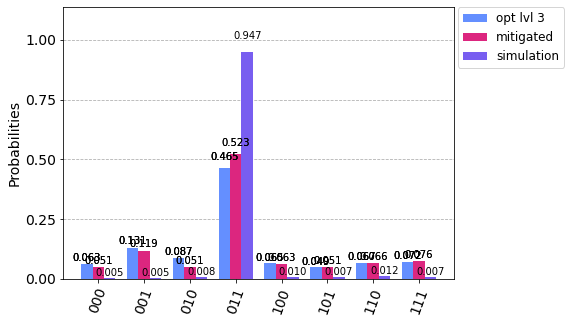

In [48]:
plot_histogram([counts_opt3, mitigated_counts, count], legend=['opt lvl 3', 'mitigated', 'simulation'])

Ao comparar o circuito otimizado e com os erros mitigados ao circuito inicial, conseguimos perceber que existem várias técnicas para melhorar os problemas de ruído quântico.

## 5. Conclusão

Como ainda estamos numa fase inícial relativamente à computação quântica, a nível de hardware ainda existem imensos problemas. Esses problemas acabam por gerar ruído.
Com isto, esse ruído gera bastantes problemas no resultado. Basta analizar que idealmente deveriamos ter $100\%$ de hipótese de obter o estado $\lvert 110 \rangle$ como estado solução, mas no entanto, mesmo após otimizar e mitigar os erros, as probabilidades são inferiores a $55\%$ (embora estes resultados tenham sido muito melhores do que o normal, continua a ser demasiado longe do que é considerado ideal). 
Enquanto pessoa que gera o código para máquina, uma das maiores preocupações, é fazer o código de maneira a que os erros sejam o menor possível.


## 6. Extra

Como ponto extra, o nosso grupo decidiu implementar uma função que gera um oráculo que marca o elemento especificado no input (parâmetro $elem$), sendo este input uma string com o elemento a procurar (apenas elementos com 3 bits).

In [55]:
def select(elem,circuit,qr):
    for i in range(len(elem)):
        if elem[i] == '0':
            circuit.x(qr[len(elem) - 1 - i])

def phase_oracle_gen(elem,circuit, qr):
    select(elem,circuit,qr)
    ccz(circuit,qr)
    select(elem,circuit,qr)

In [56]:
def buildCircuitGroverGen(elem,f):
    qr = QuantumRegister(x, 'q')
    cr = ClassicalRegister(x,'c')
    circuit = QuantumCircuit(qr,cr)
    
    init(circuit,qr)    
    
    for t in range(f):
        # phase oracle
        phase_oracle_gen(elem,circuit,qr)

        # diffuser
        diffuser(circuit,qr)
        
    circuit.measure(qr,cr)
    
    return circuit

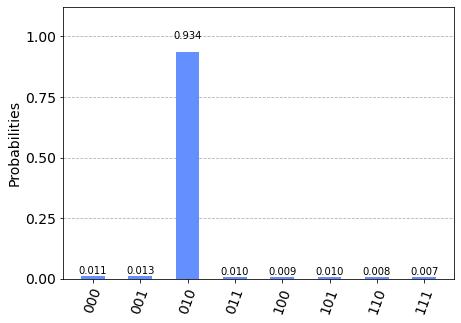

In [60]:
qc_GroverGen = buildCircuitGroverGen("010",2)
resultGen = execute(qc_GroverGen, backend_qasm, shots=shots).result()
countGen = resultGen.get_counts(qc_GroverGen)
plot_histogram(countGen)

## Anexo

In [1]:
#IMPORTS
import qiskit
import qiskit.tools.jupyter
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, transpile
from qiskit.quantum_info import Statevector
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_hinton, plot_bloch_multivector
import matplotlib.pyplot as plt
%matplotlib inline
from qiskit.tools.monitor import backend_overview, backend_monitor
from qiskit.visualization import plot_circuit_layout
from qiskit.compiler import transpile
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

#s = NºGrupo Mod 8  // Numero a procurar
s = 19 % 8
#s to bin
wb = bin(s)[2:]

# 7 = {111} then we need 3 qubits
x = 3


def init(circuit,qr):
    circuit.h(qr)
    
def ccz(circuit, qr):
    circuit.h(qr[2])
    circuit.ccx(qr[0],qr[1],qr[2])
    circuit.h(qr[2])    
    
def phase_oracle(circuit, qr):
    #muda a fase do estado |011>  -> |qr[2] qr[1] qr[0]>
    circuit.x(qr[2])
    ccz(circuit,qr)
    circuit.x(qr[2])
    
def diffuser(circuit, qr):
    circuit.h(qr)
    circuit.x(qr)
    ccz(circuit, qr)
    circuit.x(qr)
    circuit.h(qr)
    
def buildCircuitGrover(f):
    qr = QuantumRegister(x, 'q')
    cr = ClassicalRegister(x,'c')
    circuit = QuantumCircuit(qr,cr)
    
    init(circuit,qr)    
    
    for t in range(f):
        # phase oracle
        phase_oracle(circuit,qr)

        # diffuser
        diffuser(circuit,qr)
        
    circuit.measure(qr,cr)
    
    return circuit